# Simulation with synced bags

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Load bag with Lissajous curves
from construct_traj_list import *


sim_data = load_bag('/home/anusha/2022-09-27-11-49-40.bag')
ref_traj, actual_traj, input_traj, cost_traj = compute_traj(sim_data)
sim_data.close()

TypeError: compute_traj() missing 1 required positional argument: 'str'

In [3]:
%matplotlib notebook

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>


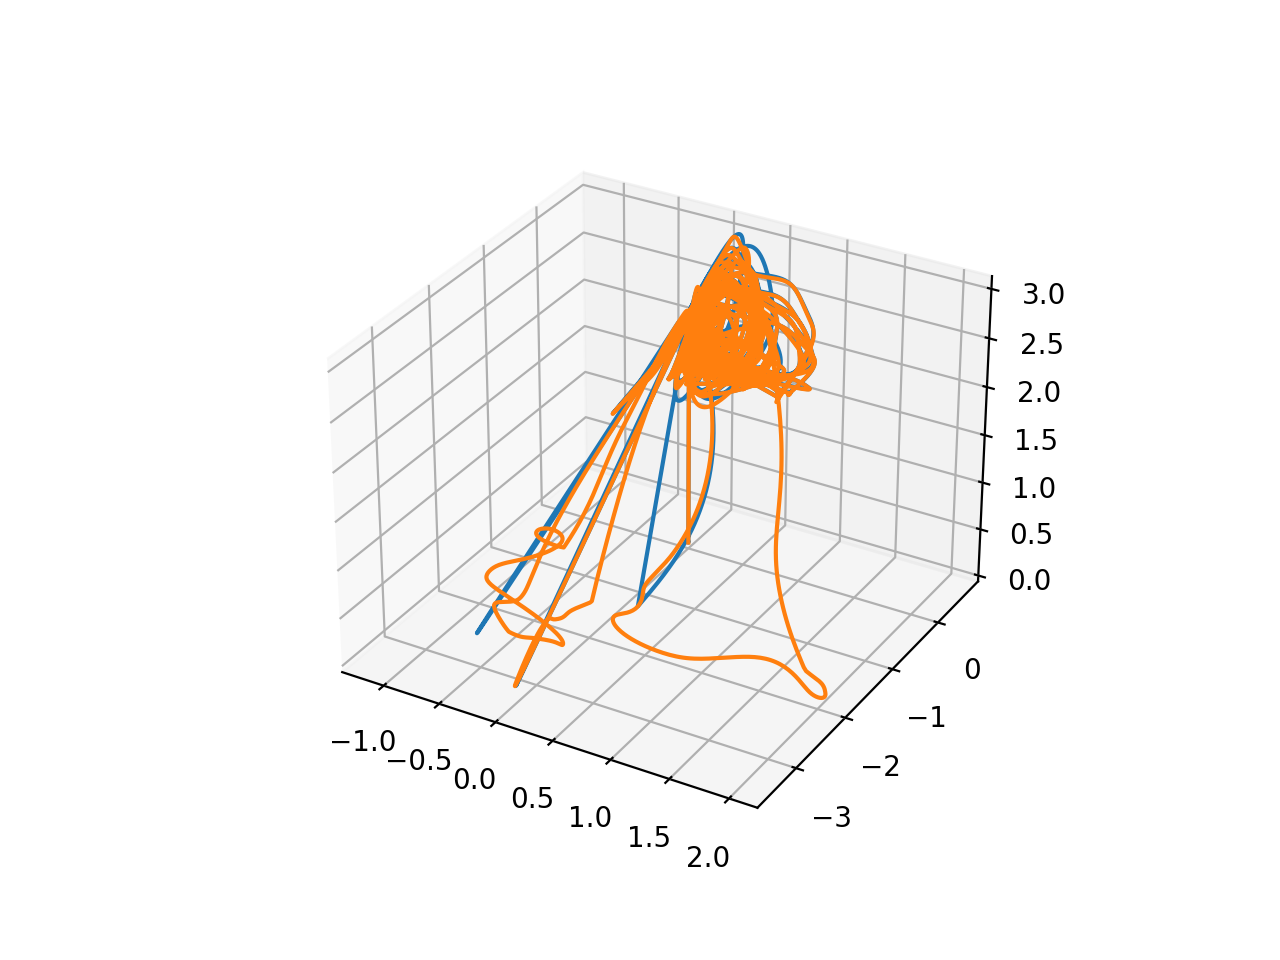

In [4]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart = 0
Tend = -1

axes.plot3D(ref_traj[Tstart:Tend, 0], ref_traj[Tstart:Tend, 1], ref_traj[Tstart:Tend, 2], label='mj-ref')
axes.plot3D(actual_traj[Tstart:Tend, 0], actual_traj[Tstart:Tend, 1], actual_traj[Tstart:Tend, 2], label='mj-actual')


In [10]:
Tstart = 0
Tend = 10000

ref_traj = ref_traj[Tstart:Tend, :]
actual_traj = actual_traj[Tstart:Tend, :]
input_traj = input_traj[Tstart:Tend, :]
cost_traj = cost_traj[Tstart:Tend]

In [3]:
from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic, nonlinear

# Construct augmented states
time_steps = 300
gamma = 0.99

idx = range(0, 14)

cost_traj = cost_traj.ravel()

ref_chunks = np.array([ref_traj[x:x + time_steps] for x in range(0, len(ref_traj)-time_steps)])
print(ref_chunks.shape)
aug_state = []
for xa, rref in zip(actual_traj[:-time_steps], ref_chunks):
    aug_state.append(np.concatenate([xa[idx], rref[:, idx].flatten()]))
aug_state = np.array(aug_state)
print(aug_state.shape)

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'cost_traj' is not defined

In [20]:
dataset = trajdata.TrajDataset(aug_state[:-1], input_traj[:-1],
                               cost_traj[:-1-time_steps, None], aug_state)
dataset.cuda()

In [21]:
p = aug_state.shape[1]
q = 4

mlpvalue = valuefunc.MLPValueFunc(p, [300, 300, 1])
mlpvalue.network = mlpvalue.network.cuda()
mlpvalue.learn(dataset, gamma, num_epoch=200, batch_size=64, verbose=True, print_interval=50, lr=0.0005)

Epoch: 1 	 Training loss: 0.04493311239559874
Epoch: 51 	 Training loss: 0.00099400460117257
Epoch: 101 	 Training loss: 0.0005399192273699909
Epoch: 151 	 Training loss: 0.0002757264565680587


In [15]:
torch.save(mlpvalue, '/home/anusha/mlp_model.pt')

In [22]:
torch.save(mlpvalue.network.state_dict(), '/home/anusha/mlp_model_dict')

In [ ]:
p = aug_state.shape[1]
q = 4

icnnvalue = valuefunc.ICNNValueFunc(p, [400, 400, 1])
icnnvalue.network = icnnvalue.network.cuda()
icnnvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True, print_interval=50, lr=0.0005)

## Inference and save a pkl file

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

from trajgen import quadratic, quadrotor, nonlinear_jax

import torch
import pickle
import sys

import ruamel.yaml as yaml
from flax.training import train_state
import optax
import jax
from mlp_jax import MLP, MLP_torch
from model_learning import restore_checkpoint

from learning import valuefunc_jax, valuefunc

PI = np.pi


def generate_lissajous_traj(s, x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp, y_amp, z_amp, yaw_amp):
    """
    Function to generate Lissajous trajectory
    :return:
    """
    x = lambda a: x_amp * (1 - np.cos(2 * PI * x_num_periods * a / period))
    y = lambda a: y_amp * np.sin(2 * PI * y_num_periods * a / period)
    z = lambda a: z_amp * np.sin(2 * PI * z_num_periods * a / period)
    yaw = lambda a: yaw_amp * np.sin(2 * PI * yaw_num_periods * a / period)
    return np.array([x(s), y(s), z(s), yaw(s)])


def generate_polynomial_trajectory(start, end, T, order):
    """
    Generates a polynomial trajectory from start to end over time T
    start: start state
    end: end state
    T: total time
    order: order of the polynomial
    """
    # Define the time vector
    t = np.linspace(0, 1, T)

    # Solve for the polynomial coefficients
    #coeffs = np.zeros(order + 1)
    coeffs = np.polyfit(t, t * (end - start) + start, order)

    # Evaluate the polynomial at the desired time steps
    #polynomial = np.zeros(T)
    polynomial = np.polyval(coeffs[::-1], t)
    trajectory = polynomial + start

    return coeffs


def load_torch_model(trained_model_state):
    # Load checkpoint
    weights = trained_model_state.params['params']

    # Store weights of the network
    hidden_wts = [
        [weights['linear_0']['kernel'], weights['linear_0']['bias']],
        [weights['linear_1']['kernel'], weights['linear_1']['bias']],
        [weights['linear_2']['kernel'], weights['linear_2']['bias']],
    ]
    linear2_wts = [weights['linear2']['kernel'], weights['linear2']['bias']]

    def convert_torch(x):
        print(x.shape)
        return torch.from_numpy(np.array(x))

    # Create network
    inp_size = 1204
    num_hidden = [500, 400, 200]
    mlp_t = MLP_torch(inp_size, num_hidden)

    for i in range(3):
        mlp_t.hidden[i].weight.data = convert_torch(hidden_wts[i][0]).T
        mlp_t.hidden[i].bias.data = convert_torch(hidden_wts[i][1])

    mlp_t.linear2.weight.data = convert_torch(linear2_wts[0]).T
    mlp_t.linear2.bias.data = convert_torch(linear2_wts[1])
    return mlp_t


def simple_replan(selected_waypoints, duration, order, p, vf, rho):
    """
    Function to generate a new trajectory using the selected waypoints
    """


    # Generate time samples for the new trajectory
    ts = np.linspace(0, duration, selected_waypoints.shape[0])
    
    new_traj_coeffs = np.zeros([p, len(selected_waypoints)-1, order + 1])

    #nn_coeff = quadrotor.generate(torch.tensor(selected_waypoints.T), ts, order, duration * 100, p, rho, vf, torch.tensor(new_traj_coeffs),
    #                              num_iter=150, lr=0.0001)
    
    
    _, min_jerk_coeffs = quadratic.generate(selected_waypoints, ts, order, duration * 100, p, None, 0)
    nn_coeff = nonlinear_jax.generate(selected_waypoints, ts, order, duration * 100, p, rho, vf, min_jerk_coeffs,
                                  num_iter=100, lr=0.0001)
    # print("new_traj_coeffs: ", new_traj_coeffs)


    #return new_traj_coeffs
    print(nn_coeff)
    return nn_coeff


def save_object(obj, filename):
    """
    Function to save to a pickle file
    :param obj:
    :param filename:
    :return:
    """
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def load_object(str):
    """
    Function to load to a pickle file
    :param str:
    :return:
    """
    with open(str, 'rb') as handle:
        return pickle.load(handle)
    
    


/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-02 10:18:20.847246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anusha/Research/ws_kr/devel/lib:/opt/ros/noetic/lib
2023-07-02 10:18:20.847308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anusha/Research/ws_kr/devel/lib:/opt/ros/noetic/lib
2023-07-02 10:18:20.847313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Can

In [11]:
rho = 20

with open(r"/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/params.yaml") as f:
    yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']

# Load the trained model
model = MLP(num_hidden=num_hidden, num_outputs=1)
# Printing the model shows its attributes
print(model)

rng = jax.random.PRNGKey(427)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, 4))  # Batch size 64, input size p
# Initialize the model
params = model.init(init_rng, inp)

optimizer = optax.sgd(learning_rate=learning_rate, momentum=0.9)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

model_save = yaml_data['save_path'] + str(rho)

trained_model_state = restore_checkpoint(model_state, model_save)

#trained_model = model.bind(trained_model_state.params)

#mlp_t = load_torch_model(trained_model_state)

#print(mlp_t)

#vf = valuefunc.MLPValueFunc(mlp_t)

#vf = valuefunc_jax.MLPValueFunc(trained_model_state)

#vf.network = mlp_t

#vf = trained_model_state

vf = model.bind(trained_model_state.params)


# parameters for lissajous trajectory

np.random.seed(3)

x_amp = 2
y_amp = 2
z_amp = 0.8
yaw_amp = 0.2

x_num_periods = 2
y_num_periods = 2
z_num_periods = 2
yaw_num_periods = 2

# total period for all the trajectories
period = 6
p = 4
order = 5
Tref = period*100

movig_widow = 4
num_waypoints_per_segment = 4
duration = 3  # Duration of each replanning iteration

# Generate the waypoints for the entire trajectory
ref = generate_lissajous_traj(np.linspace(0, period, period*100+1), x_num_periods, y_num_periods, z_num_periods,
                              yaw_num_periods, period, x_amp, y_amp, z_amp, yaw_amp)
waypt = np.array(ref)[:, 0::30]
# waypt = np.array(ref)[:, 0::50]
# Get the number of segments and time samples
segments = len(waypt.T) - 1
print("Segments:", segments)
ts = np.linspace(0, period, segments + 1)

# we don't need to offset the z axis in sim
offset = min(waypt[2, :])
print("Negative offset", offset)
waypt[2, :] = waypt[2, :] - offset + 0.25

# 0515
#publish all the waypts
# mav_obj.publish_waypoints(waypt, 0.0, 0.0, 1.0, 0.5)
print(len(waypt.T))

nn_coeffs = []

# Initialize the current waypoint index
current_waypoint_index = 0 

while current_waypoint_index < len(waypt.T) - num_waypoints_per_segment + 1:
    print("current_waypoint_index", current_waypoint_index)
    # Determine the start and end indices of the next waypoints and trajectory to consider
    start_idx = current_waypoint_index
    end_idx = start_idx + num_waypoints_per_segment
    # print("start_idx", start_idx)
    # print("end_idx", end_idx)

    # Select the waypoints for replanning
    selected_waypoints = waypt.T[start_idx:end_idx]
    print("selected_waypoints's shape", selected_waypoints.shape)


    # Replan the trajectory based on previous and next waypoints
    nn_coeffs.append(simple_replan(selected_waypoints, duration, order, p, vf, rho))

    Tref = duration * 100

    # Update the current waypoint index
    current_waypoint_index += movig_widow

    print("current_waypoint_index after update", current_waypoint_index)

    # Compute position, velocity, acceleration, jerk, yaw, and yaw rate from the new trajectory
    segment_new = len(selected_waypoints.T) - 1
    ts_new = np.linspace(0, duration, segment_new + 1)
    
save_object(nn_coeffs, r"/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/nn_coeffs"+str(rho)+".pkl")
    

MLP(
    # attributes
    num_hidden = [500, 400, 200]
    num_outputs = 1
)
Segments: 20
Negative offset -0.7608452130361233
21
current_waypoint_index 0
selected_waypoints's shape (4, 4)
Initial [0.         0.38196601 1.38196601 2.61803399]
Num coeffs 18
Ref (1200,)
Constraint matrix (14, 18)
b (4, 14)
[[[-1.8933769e-03  5.2378955e-03 -4.3982011e-03  8.4321554e-14
    4.2671476e-13  6.8093198e-13]
  [ 6.7209761e-04 -1.7771939e-03  1.3145610e-03 -7.6062240e-02
    5.8171165e-01  3.8196602e-01]
  [-7.7350123e-04  1.9432586e-03 -1.1387663e-03  7.6857734e-01
    1.8513227e+00  1.3819660e+00]]

 [[-4.8876400e-03  1.3541282e-02 -1.1463300e-02  4.9540423e-14
    2.4072966e-13  3.7217554e-13]
  [ 1.5214467e-03 -4.1989540e-03  3.5313393e-03 -7.8341591e-01
    1.7575862e+00  1.1755705e+00]
  [-5.6167104e-04  1.5599993e-03 -1.3169057e-03 -1.6974935e-01
    1.0116613e-02  1.9021131e+00]]

 [[-1.9559001e-03  5.4184301e-03 -4.5869946e-03  1.9816104e-14
    9.6290997e-14  1.0108452e+00]
  [ 6.087506